In [1]:
%matplotlib inline
from __future__ import division,print_function
#from PIL import Image
import gc,re

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input, LSTM, GRU, Embedding, Convolution1D, MaxPooling1D, MaxPool1D
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

import pandas
import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from keras.layers.merge import Add,Dot,Concatenate

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\User\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Get raw data
raw_data = pandas.read_hdf("raw_data_legacy.hdf.gz", "root")
feature_df = pandas.read_hdf("feature_data_legacy.hdf.gz", "root")


In [4]:
np.random.seed(7)

In [5]:
#There are 64 features including output variables
len(raw_data.columns)

64

In [6]:
#Use unique to get possible values for each feature
raw_data['case_outcome_disposition'].unique()

array([ -1.,   1.,   0.,  nan])

In [8]:
feature_df_names = feature_df.columns
len(feature_df_names)

1725

Remove all the outcome variables mentioned on SCDB website, to prevent model from learning any internal dependencies in these. Out final predictions are for "case_outcome_disposition".

In [9]:
outcome = ['decisionType','declarationUncon','caseDisposition','case_outcome_disposition',\
           'partyWinning','caseDispositionUnusual','precedentAlteration','justice_outcome_disposition']

for feature in outcome:
    if feature in feature_df_names:
        print(" YES ")
    else : 
        print("NO")

NO
NO
NO
NO
NO
NO
NO
NO


In [10]:
rest = []
for feature in feature_df_names:
    if feature.startswith("term") or feature.startswith("justice") or feature.startswith("respondent") \
        or feature.startswith("petitioner") or feature.startswith("natural") or feature.startswith("argument")\
        or feature.startswith("issue") or feature.startswith("decision_month") :
        pass
    else:
        rest.append(feature)

All the other input features are appended, and for every categorical feature, a pattern of "name"_number was used.

In [11]:
print(rest)

['decision_delay',
 'jurisdiction_-1',
 'jurisdiction_1',
 'jurisdiction_2',
 'jurisdiction_3',
 'jurisdiction_4',
 'jurisdiction_5',
 'jurisdiction_6',
 'jurisdiction_7',
 'jurisdiction_8',
 'jurisdiction_9',
 'jurisdiction_10',
 'jurisdiction_12',
 'jurisdiction_13',
 'jurisdiction_14',
 'jurisdiction_15',
 'admin_action_-1',
 'admin_action_1',
 'admin_action_2',
 'admin_action_3',
 'admin_action_4',
 'admin_action_5',
 'admin_action_6',
 'admin_action_7',
 'admin_action_8',
 'admin_action_9',
 'admin_action_10',
 'admin_action_11',
 'admin_action_12',
 'admin_action_13',
 'admin_action_14',
 'admin_action_15',
 'admin_action_16',
 'admin_action_17',
 'admin_action_18',
 'admin_action_20',
 'admin_action_21',
 'admin_action_22',
 'admin_action_24',
 'admin_action_25',
 'admin_action_26',
 'admin_action_27',
 'admin_action_28',
 'admin_action_29',
 'admin_action_30',
 'admin_action_31',
 'admin_action_32',
 'admin_action_33',
 'admin_action_34',
 'admin_action_35',
 'admin_action_36',

Create Target and Drop all the outcome variables from the dataframe.

In [12]:
whole_data = raw_data.copy()
target = whole_data['justice_outcome_disposition']
whole_data.drop(outcome,axis=1, inplace=True)

whole_data.shape

(249793, 56)

In [13]:
feature_names = whole_data.columns
feature_names

Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term', 'naturalCourt',
       'chief', 'docket', 'caseName', 'dateArgument', 'dateRearg',
       'petitioner', 'petitionerState', 'respondent', 'respondentState',
       'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc',
       'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState',
       'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'voteUnclear', 'issue', 'issueArea',
       'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1',
       'authorityDecision2', 'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter',
       'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice',
       'justiceName', 'vote', 'opinion', 'direction', 'majority',
       'firstAgreement', 'secondAgreement', 'lc_case_outcome_disposition'],
      dtype='object')

In [14]:
whole_data['caseId'].unique()

array(['1791-001', '1791-002', '1792-001', ..., '1917-218', '1915-245', '1908-203'], dtype=object)

Some preprocessing on the data before creating embedding
1. Fill all nan with -10
2. Create a dictionary by giving a number to each possibly unique value of the feature. 

In [15]:
list_dict = []
for feature in feature_names:
    whole_data[feature] = whole_data[feature].fillna(-10)
    n_features = whole_data[feature].unique()
    feature2idx = {o : i for i,o in enumerate(n_features)}
    list_dict.append(feature2idx)
len(list_dict)

56

Replace all values in main dataframe with new numerical values.

In [16]:
for i,feature in enumerate(feature_names):
    whole_data[feature] = whole_data[feature].apply(lambda x : list_dict[i][x])

In [ ]:
whole_data['lawType'].unique()

Create an Input and Embedding Layer for each of the categorical features.

In [17]:
inputs = []
embeddings = []
EMB_LEN = 50
for feature in feature_names:
    inp = Input(shape=(1,), name=feature)
    n_features = whole_data[feature].nunique()
    emb_name = 'emb_'+feature
    emb = Embedding(n_features, EMB_LEN, input_length=1, name=emb_name)(inp)
    inputs.append(inp)
    embeddings.append(emb)

In [18]:
inputs[-2:]

[/secondAgreement, /lc_case_outcome_disposition]

In [19]:
embeddings[-2:]

[Reshape{3}.0, Reshape{3}.0]

Concatenate all the embeddings.

In [21]:
final_embs = Concatenate()(embeddings)

Create the model with 
1. LSTM layer with 200 timesteps for the hidden cell and only one layer.
2. Dense layer 3 units for 3 decision types - Affirm, Reverse, No Change (on the decision from lower courts).

Observations in the model summary:

1. In Model summary we can observe that for each feature there is an input layer, and embedding layer with dimension of 50.
e.g  caseId (InputLayer)             (None, 1)            0   
     emb_caseId (Embedding)          (None, 1, 50)        1427150     caseId[0][0]          

2. The concatenate layer has 2800 as dimension size because we have 56 features and 56*50 = 2800.
    concatenate_1 (Concatenate)     (None, 1, 2800)
    
3. The LSTM layer shows parameters of 2400800. This can be explained by digging into Keras's implementation of LSTM Cell and understanding of weight matrices used for LSTM. There are 4 different weight matrices used for input, forget, output, and update gates. each will have one dimension as number LSTM cells, hence 200*4 = 800. The input parameter size is 2800 from previous layer , hence (2800+200)*800 = 2400000. 
For each of these weight matrices there are biases, hence 800 biases. = total is 2400800. 
    lstm_1 (LSTM)                   (None, 200)          2400800     concatenate_1[0][0] 


In [24]:
lstm = LSTM(200)(final_embs)
preds = Dense(3, activation = 'softmax')(lstm)

model = Model(inputs=inputs, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caseId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
docketId (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
caseIssuesId (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
voteId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
dateDecisi

emb_lexisCite (Embedding)       (None, 1, 50)        1424450     lexisCite[0][0]                  
__________________________________________________________________________________________________
emb_term (Embedding)            (None, 1, 50)        11100       term[0][0]                       
__________________________________________________________________________________________________
emb_naturalCourt (Embedding)    (None, 1, 50)        5150        naturalCourt[0][0]               
__________________________________________________________________________________________________
emb_chief (Embedding)           (None, 1, 50)        850         chief[0][0]                      
__________________________________________________________________________________________________
emb_docket (Embedding)          (None, 1, 50)        341950      docket[0][0]                     
__________________________________________________________________________________________________
emb_caseNa

__________________________________________________________________________________________________
emb_firstAgreement (Embedding)  (None, 1, 50)        5000        firstAgreement[0][0]             
__________________________________________________________________________________________________
emb_secondAgreement (Embedding) (None, 1, 50)        3250        secondAgreement[0][0]            
__________________________________________________________________________________________________
emb_lc_case_outcome_disposition (None, 1, 50)        200         lc_case_outcome_disposition[0][0]
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1, 2800)      0           emb_caseId[0][0]                 
                                                                 emb_docketId[0][0]               
                                                                 emb_caseIssuesId[0][0]           
          

We have used adam optimizer, with categorical crossentropy for multi class classification. 

Note: Commenting on these details might appear unnecessary, but this was a project done by us for an Introduction to Machine Learning course, so deciding on any hyperparameters was a herculean task, when we started this project. 

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

Split data to Train and Test (80-20)

In [26]:
data = whole_data.as_matrix()
rows = round(0.8*len(data))
X_train = data[0:rows]
X_test = data[rows:len(data)]
y_train = target[0:rows]
y_test = target[rows:len(data)]

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(199834, 56) (49959, 56) (199834, 3) (49959, 3)


In [29]:
list_of_inputs = []
for i,feature in enumerate(feature_names):
    list_of_inputs.append(X_train[:,i])
len(list_of_inputs)

56

Train the model with mini batch size of 512, and validation split of 20, hence we had 60-20-20 split for train-valid-test.

In [ ]:
model.fit(
list_of_inputs,
y_train,
batch_size=512,
epochs=2,
validation_split=0.2)

In [31]:
list_of_inputs_test = []
for i,feature in enumerate(feature_names):
    list_of_inputs_test.append(X_test[:,i])
len(list_of_inputs_test)

56

We test accuracy on the test examples, save weights for future use. (Next time we want the code, we wouldn't need to do the training again, we just reload the saved weights.)

In [ ]:
model.evaluate(list_of_inputs_test,y_test)

In [ ]:
model.save_weights(filepath='embeddings_100_lstm_50_emb.h5')

In [30]:
model.load_weights('embeddings_100_lstm_50_emb.h5')

In [32]:
model.evaluate(list_of_inputs_test,y_test)

49959/49959 [==============================] - 694s 14ms/step


[0.62283508878180482, 0.77831822094117176]

Now we have seen very good accuracy on our test and validation sets, we wanted to visualize the model's weights and attempt to explaining its performance. 

In [38]:
layer_weights = []
for i in range(62,115): 
    layer_weights.append(model.get_layer(index=i).get_weights())
len(layer_weights)

53

In [39]:
layer_weights[3][0].shape

(222, 50)

These are all the layers of our model

In [40]:
for i,layer in enumerate(model.layers):
    print(str(i) + " " + str(layer))

0 <keras.engine.topology.InputLayer object at 0x000002813BE5EFD0>
1 <keras.engine.topology.InputLayer object at 0x000002812C4600F0>
2 <keras.engine.topology.InputLayer object at 0x0000028142209588>
3 <keras.engine.topology.InputLayer object at 0x000002814465CC88>
4 <keras.engine.topology.InputLayer object at 0x0000028144467E10>
5 <keras.engine.topology.InputLayer object at 0x00000281421BD8D0>
6 <keras.engine.topology.InputLayer object at 0x000002821CA51588>
7 <keras.engine.topology.InputLayer object at 0x000002812C2F4470>
8 <keras.engine.topology.InputLayer object at 0x000002814467C908>
9 <keras.engine.topology.InputLayer object at 0x00000281444D4400>
10 <keras.engine.topology.InputLayer object at 0x000002821D0478D0>
11 <keras.engine.topology.InputLayer object at 0x0000028144638748>
12 <keras.engine.topology.InputLayer object at 0x00000281444337B8>
13 <keras.engine.topology.InputLayer object at 0x000002821D055B38>
14 <keras.engine.topology.InputLayer object at 0x0000028144411710>
15 <k

As we can see layer index 113 was the LSTM layer, so getting weight matrix from there will be useful to understand how LSTM learnt the Scotus database.
Many of the following cell show our attempt at understanding the weights, but we couldn't make any extraordinary conclusions.

In [41]:
w = model.get_layer(index=113).get_weights()

In [42]:
len(w)

3

In [43]:
w[0][:,201:401].shape

(2800, 200)

In [44]:
forget = w[0][:,200:400]
cell_state = w[0][:,400:600]
print(forget.shape,cell_state.shape)

(2800, 200) (2800, 200)


In [45]:
w[0].shape, w[1].shape, w[2].shape

((2800, 800), (200, 800), (800,))

In [46]:
w = w[0]

In [47]:
w.shape

(2800, 800)

In [48]:
m = np.mean(w,axis=1)

In [49]:
m.shape

(2800,)

In [50]:
r = m.reshape((56,50))

In [51]:
r.shape

(56, 50)

In [52]:
f = np.mean(r,axis=1)

In [53]:
f.shape

(56,)

In [54]:
f

array([ -3.5498e-03,  -8.5275e-04,  -3.1704e-03,   6.6874e-04,  -7.9836e-04,   2.4339e-03,
        -1.6356e-03,   1.6938e-03,   2.8165e-03,   1.6083e-03,  -9.6129e-04,  -5.4761e-04,
        -8.5831e-04,   6.7406e-04,  -2.2296e-03,  -4.7661e-03,   4.5844e-03,   7.0747e-04,
         4.3687e-04,  -7.2478e-04,   7.7356e-04,   1.3487e-03,  -2.5843e-03,   2.3682e-03,
        -7.4253e-04,   3.8426e-03,  -3.9204e-04,  -3.2995e-03,  -5.0061e-03,  -3.3755e-03,
         6.7161e-04,  -9.8243e-04,   2.5013e-03,  -6.8039e-04,  -1.9558e-04,  -1.4341e-05,
         3.6960e-03,   2.6611e-03,  -2.3366e-03,   2.8223e-03,   1.1580e-04,  -1.9930e-03,
        -4.9340e-04,  -2.4575e-03,  -7.1970e-03,   5.5746e-04,  -1.0291e-02,   2.3363e-03,
         2.0191e-04,   1.9749e-02,   3.6748e-04,   1.1186e-04,   9.3439e-03,   9.9410e-04,
         3.2639e-03,   4.8151e-04], dtype=float32)

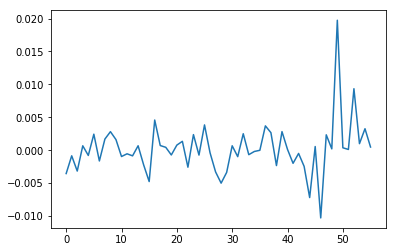

In [55]:
plt.plot(f)

In [56]:
maxi = np.argmax(f)

In [57]:
maxi

49

We tried to get a feature which influenced the most for the correct decisions. In our case it was "vote".

In [58]:
feature_names[maxi]

'vote'

Since we have used Embedding layers for all categorical variables, we have also researched on how to visualize these.
One straight forward way is to:
    1. Get weights learnt for the embeddings
    2. Perform TSNE on the weight matrix and reduce to two dimensions

We showed the steps for one feature as a trial, then create TSNE representations for most of the input features.

Why is this useful?
1. The embedding layer weights i.e. the embeddings for a given feature are learnt by model based during training. 
2. This implies that the distance / positioning of embedding vector for values of the feature reveal the correlations among these values in influencing the outcome/prediction.
    e.g. If Supreme court judge has rejected 10 lower court decisions, out of which 4 are of lawtype 1, and 5 are of lawtype 2, the embedding for lawtype 1 and 2 might be close by in 2 D space as they have influenced the decision similarly.
    


In [61]:
em_law = model.get_layer(name="emb_lawType").get_weights()

In [62]:
em_law[0].shape,type(em_law[0])

((9, 50), numpy.ndarray)

In [63]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(em_law[0])

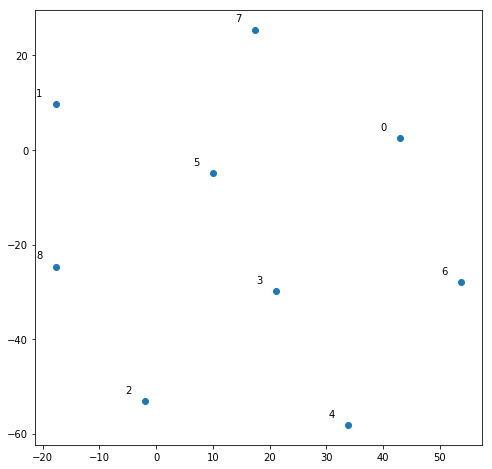

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
laws = whole_data['lawType'].unique()
for i, txt in enumerate(laws):
    plt.annotate(txt, (X_tsne[i, 0],X_tsne[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.savefig('lawtype_embedding.pdf')

This is a list of most of our features, excluding ones such as caseId, who have huge number of unique values (~25k), and performing TSNE on them will give an extremely crowded, and mostly incomprehensible graph.
We print the unique values for all these features. For future, even "lawMinor" can be removed. 

In [68]:
all_em = ['dateRearg',
       'petitioner', 'petitionerState', 'respondent', 'respondentState',
       'jurisdiction', 'adminAction', 'adminActionState', 'threeJudgeFdc',
       'caseOrigin', 'caseOriginState', 'caseSource', 'caseSourceState',
       'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'voteUnclear', 'issue', 'issueArea',
       'decisionDirection', 'decisionDirectionDissent', 'authorityDecision1',
       'authorityDecision2', 'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter',
       'majOpinAssigner', 'splitVote', 'majVotes', 'minVotes', 'justice',
       'justiceName', 'vote', 'opinion', 'direction', 'majority',
       'firstAgreement', 'secondAgreement', 'lc_case_outcome_disposition']



In [69]:
for i,e in enumerate(all_em):
    print(i,e,len(whole_data[e].unique()))

0 dateRearg 537
1 petitioner 272
2 petitionerState 58
3 respondent 258
4 respondentState 59
5 jurisdiction 15
6 adminAction 116
7 adminActionState 56
8 threeJudgeFdc 3
9 caseOrigin 206
10 caseOriginState 55
11 caseSource 187
12 caseSourceState 55
13 lcDisagreement 3
14 certReason 14
15 lcDisposition 13
16 lcDispositionDirection 4
17 voteUnclear 3
18 issue 279
19 issueArea 15
20 decisionDirection 4
21 decisionDirectionDissent 3
22 authorityDecision1 8
23 authorityDecision2 8
24 lawType 9
25 lawSupp 187
26 lawMinor 2896
27 majOpinWriter 109
28 majOpinAssigner 62
29 splitVote 2
30 majVotes 11
31 minVotes 6
32 justice 114
33 justiceName 114
34 vote 9
35 opinion 4
36 direction 3
37 majority 3
38 firstAgreement 100
39 secondAgreement 65
40 lc_case_outcome_disposition 4


Since the embedding layers have a prefix of emb_ we need to add that to feature name , before trying to fetch the layer weights from the model. 

In [70]:
all_em_emb = ["emb_"+e for e in all_em]

In [71]:
all_em[:2][-1:],all_em_emb[:2]

(['petitioner'], ['emb_dateRearg', 'emb_petitioner'])

Perform TSNE for all the features in above list, similar to the example for emb_lawType.

type <class 'numpy.ndarray'> len 1 shape (537, 50) of layer weights
len of ydata 537
type <class 'numpy.ndarray'> len 1 shape (272, 50) of layer weights
len of ydata 272
type <class 'numpy.ndarray'> len 1 shape (58, 50) of layer weights
len of ydata 58
type <class 'numpy.ndarray'> len 1 shape (258, 50) of layer weights
len of ydata 258
type <class 'numpy.ndarray'> len 1 shape (59, 50) of layer weights
len of ydata 59
type <class 'numpy.ndarray'> len 1 shape (15, 50) of layer weights
len of ydata 15
type <class 'numpy.ndarray'> len 1 shape (116, 50) of layer weights
len of ydata 116
type <class 'numpy.ndarray'> len 1 shape (56, 50) of layer weights
len of ydata 56
type <class 'numpy.ndarray'> len 1 shape (3, 50) of layer weights
len of ydata 3
type <class 'numpy.ndarray'> len 1 shape (206, 50) of layer weights
len of ydata 206
type <class 'numpy.ndarray'> len 1 shape (55, 50) of layer weights
len of ydata 55
type <class 'numpy.ndarray'> len 1 shape (187, 50) of layer weights
len of ydat

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


type <class 'numpy.ndarray'> len 1 shape (3, 50) of layer weights
len of ydata 3
type <class 'numpy.ndarray'> len 1 shape (8, 50) of layer weights
len of ydata 8
type <class 'numpy.ndarray'> len 1 shape (8, 50) of layer weights
len of ydata 8
type <class 'numpy.ndarray'> len 1 shape (9, 50) of layer weights
len of ydata 9
type <class 'numpy.ndarray'> len 1 shape (187, 50) of layer weights
len of ydata 187
type <class 'numpy.ndarray'> len 1 shape (2896, 50) of layer weights
len of ydata 2896
type <class 'numpy.ndarray'> len 1 shape (109, 50) of layer weights
len of ydata 109
type <class 'numpy.ndarray'> len 1 shape (62, 50) of layer weights
len of ydata 62
type <class 'numpy.ndarray'> len 1 shape (2, 50) of layer weights
len of ydata 2
type <class 'numpy.ndarray'> len 1 shape (11, 50) of layer weights
len of ydata 11
type <class 'numpy.ndarray'> len 1 shape (6, 50) of layer weights
len of ydata 6
type <class 'numpy.ndarray'> len 1 shape (114, 50) of layer weights
len of ydata 114
type <

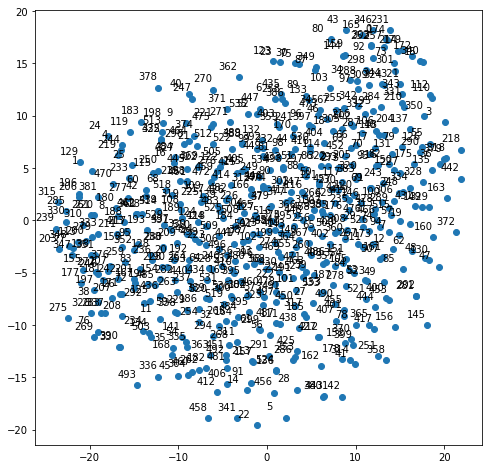

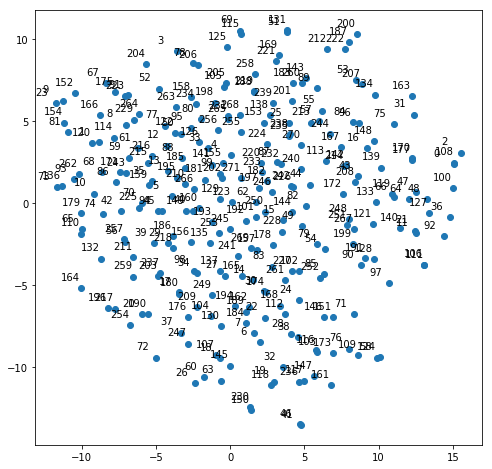

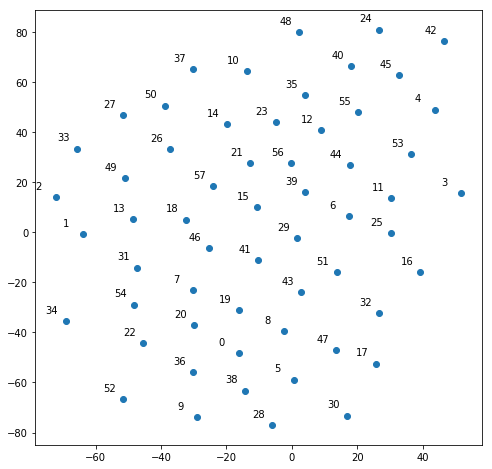

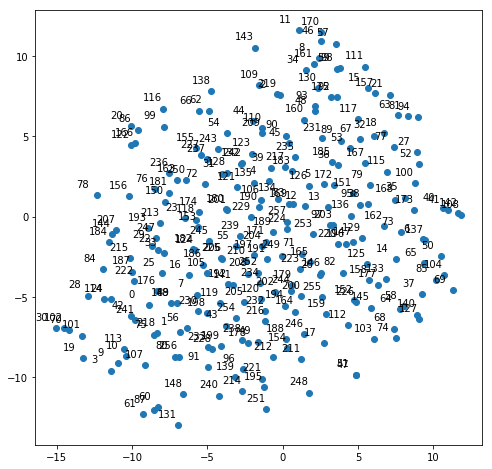

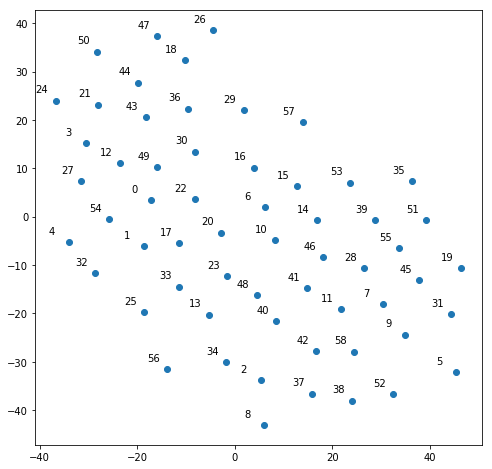

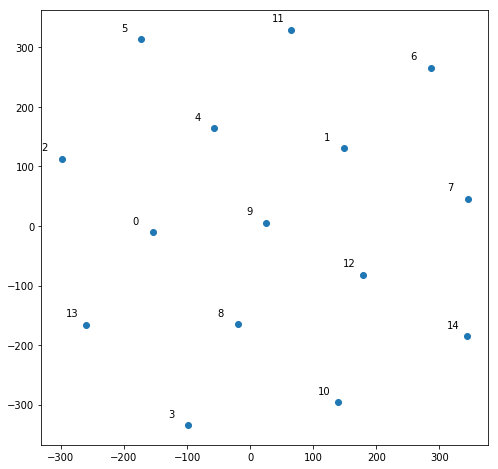

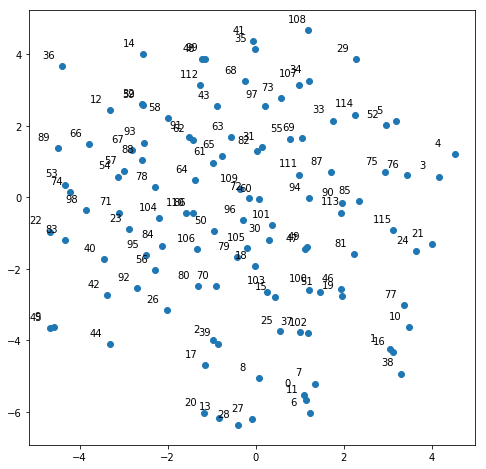

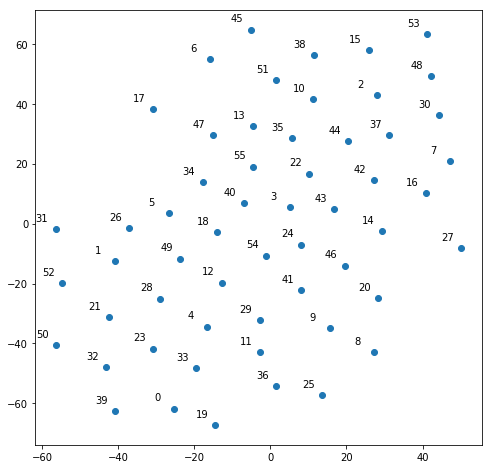

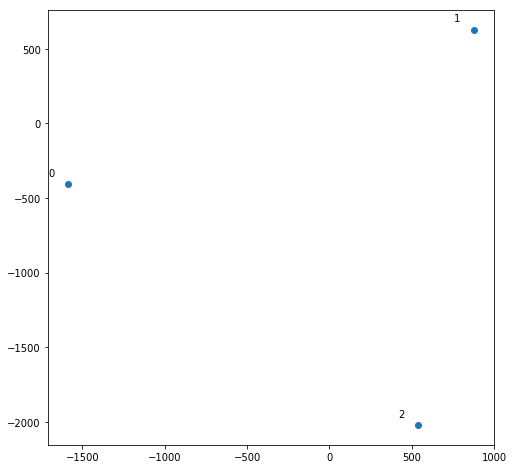

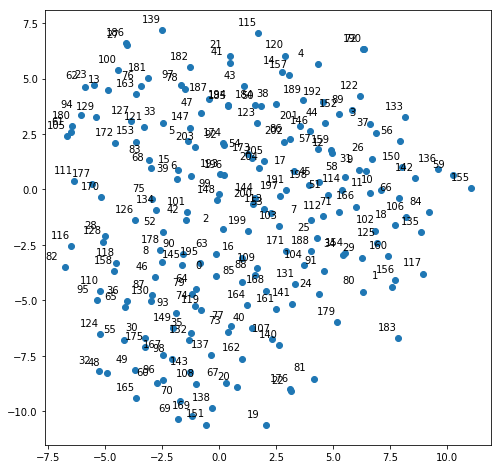

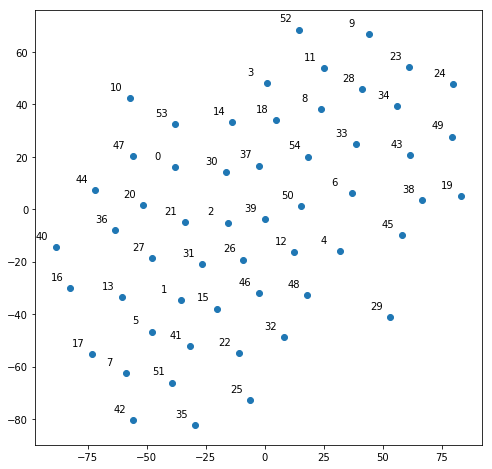

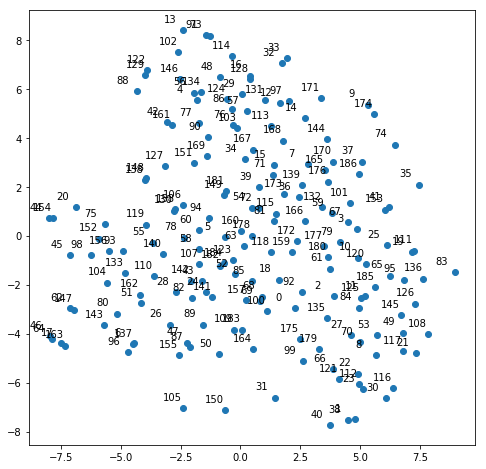

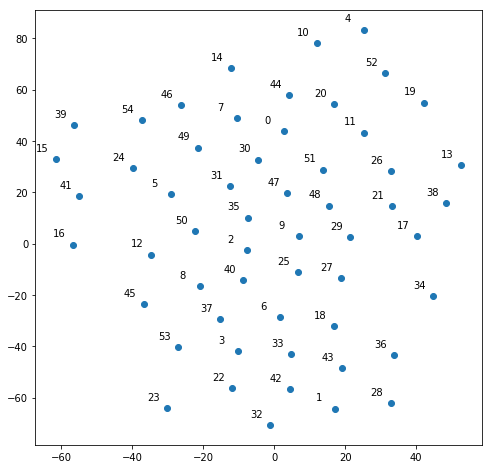

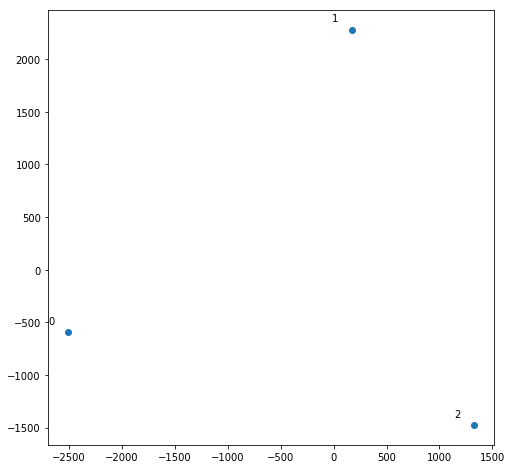

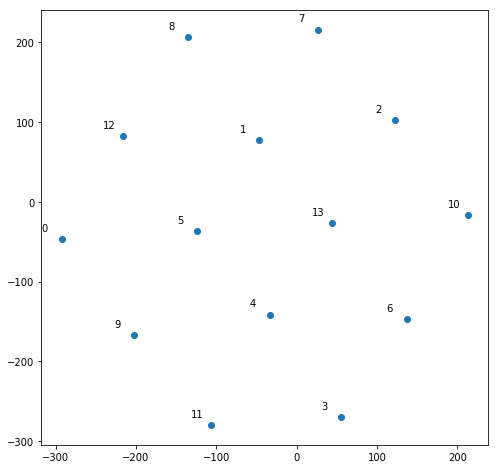

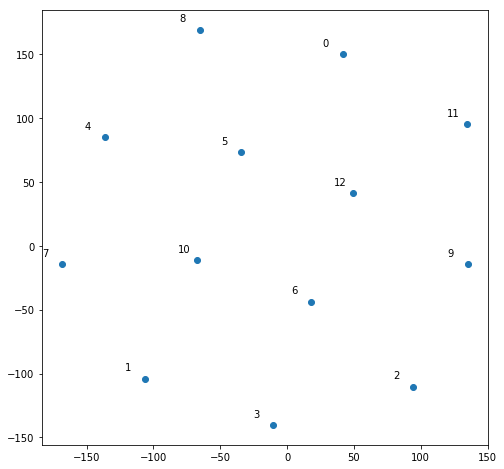

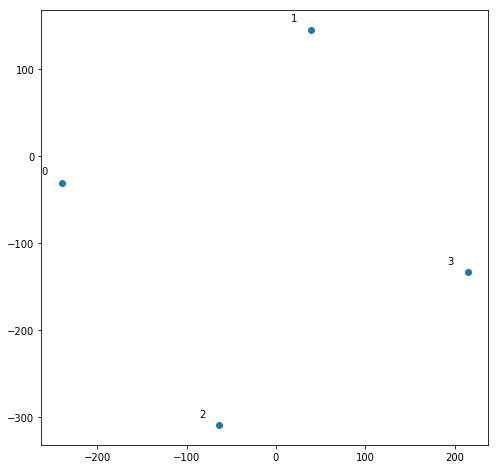

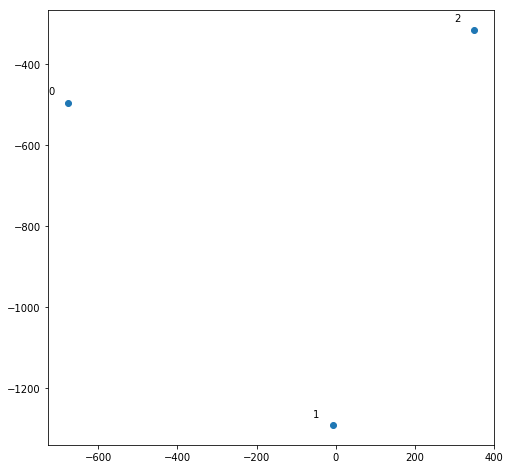

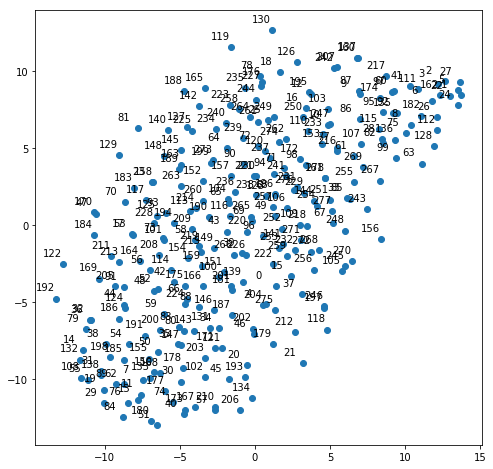

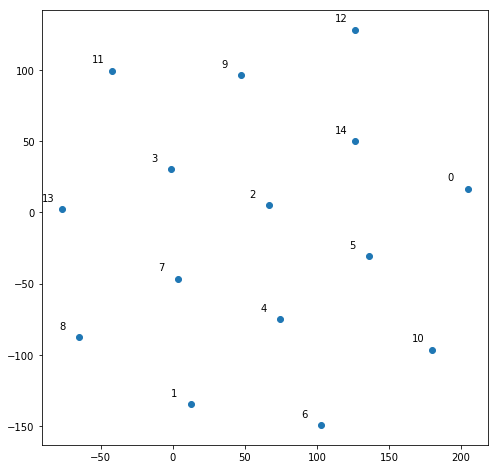

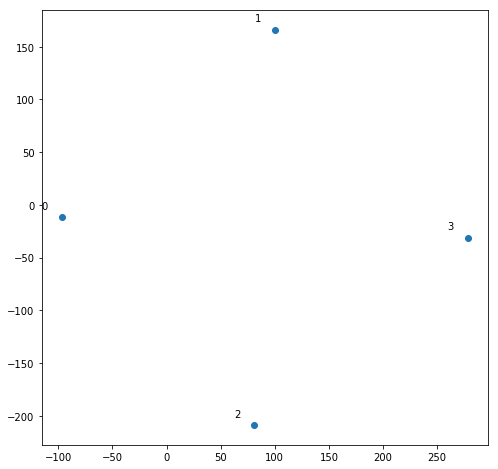

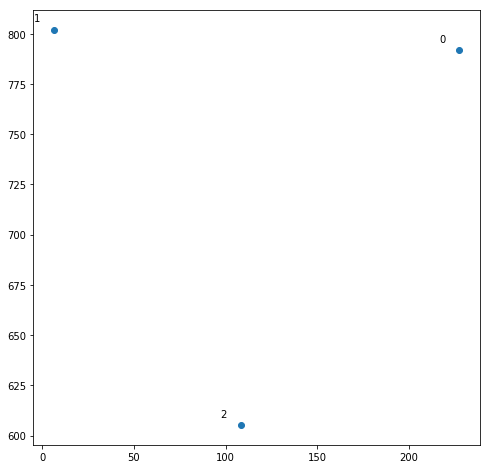

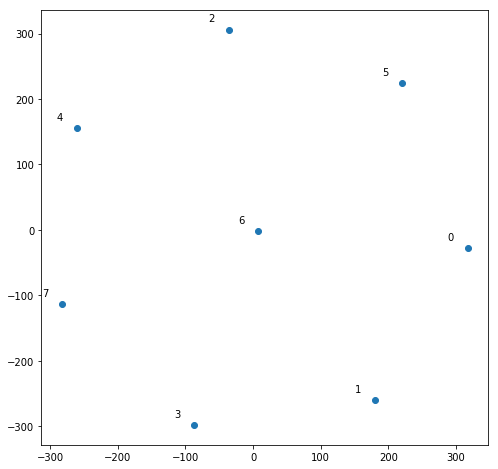

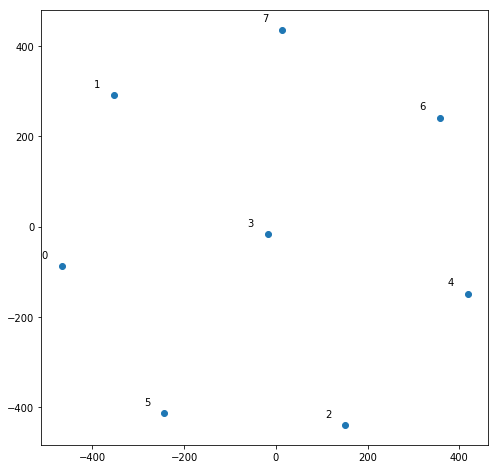

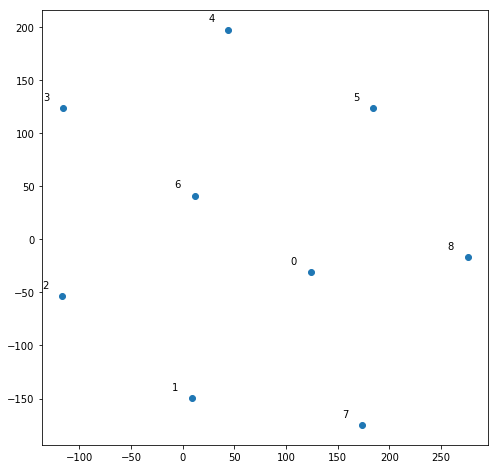

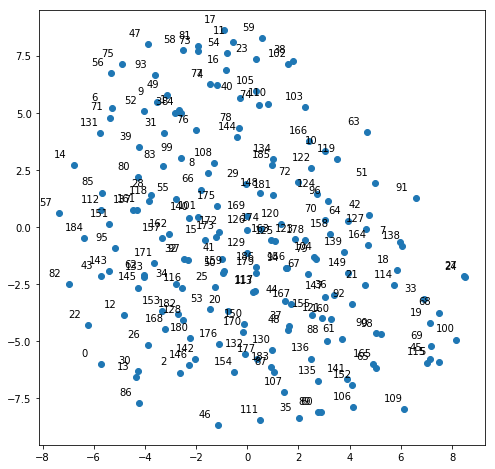

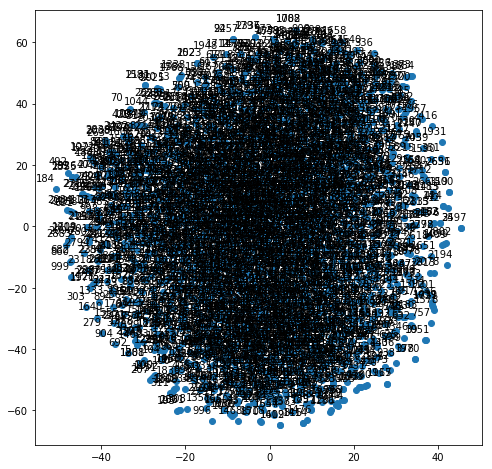

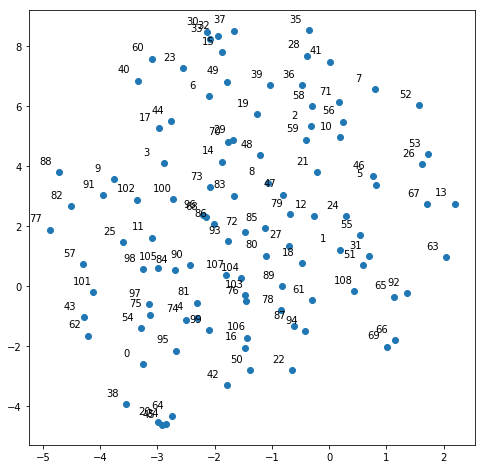

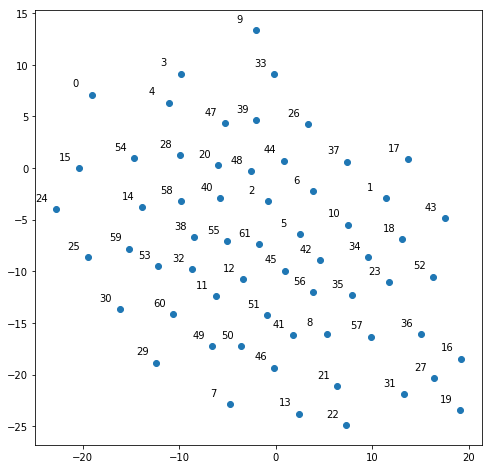

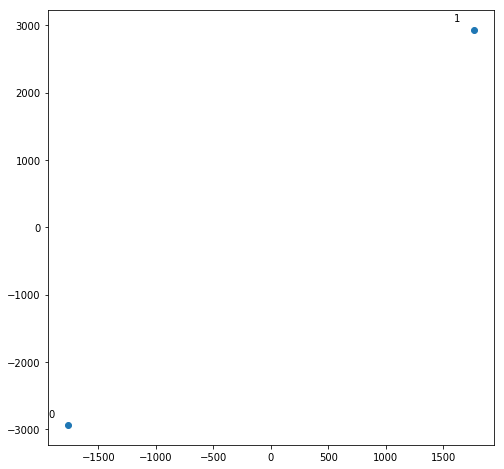

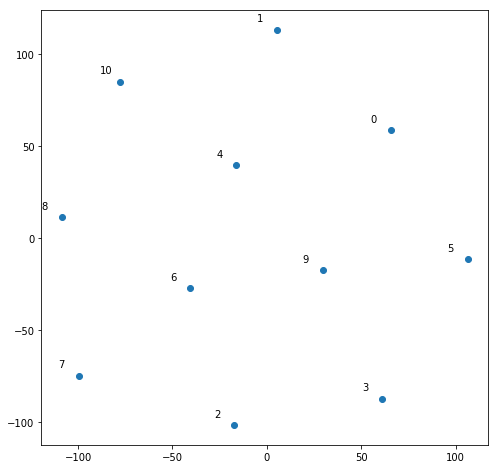

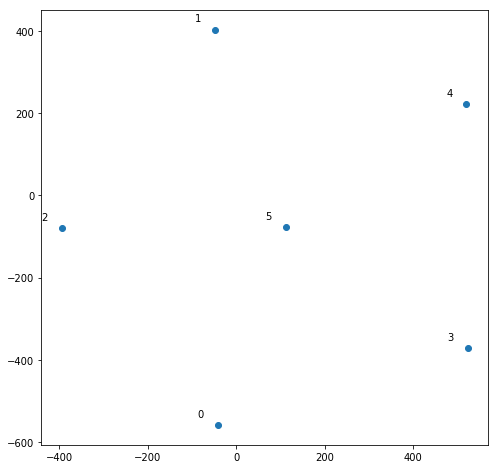

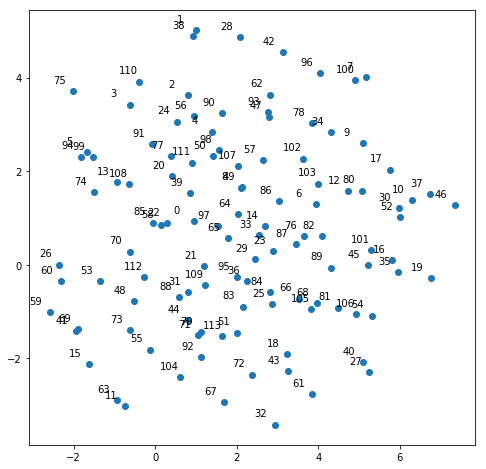

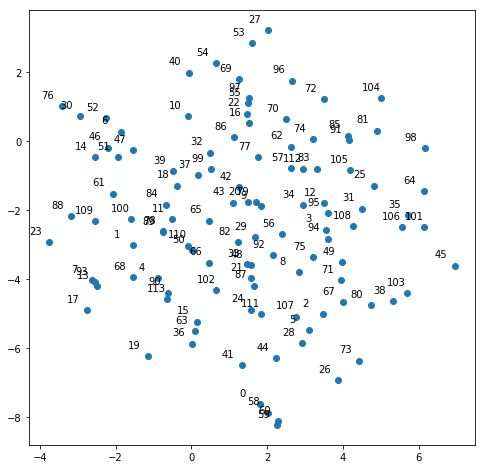

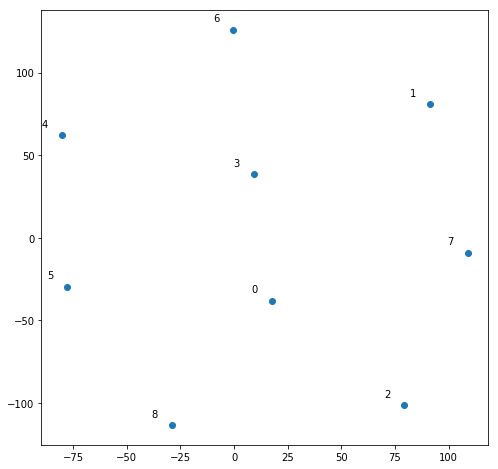

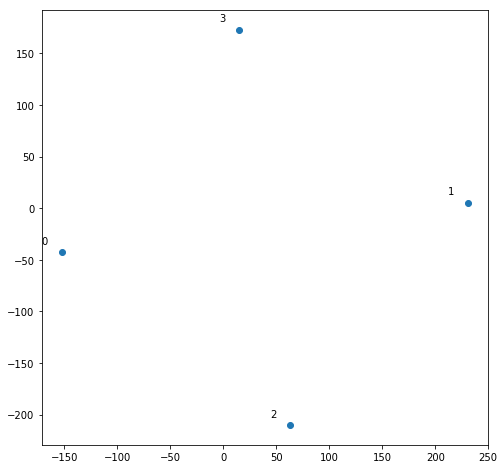

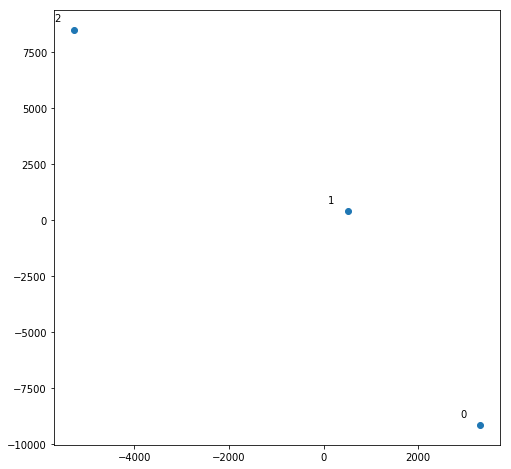

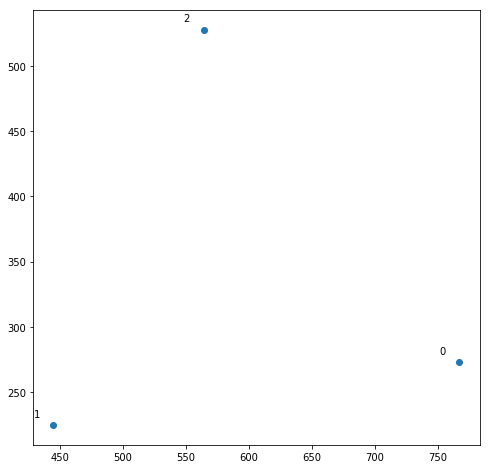

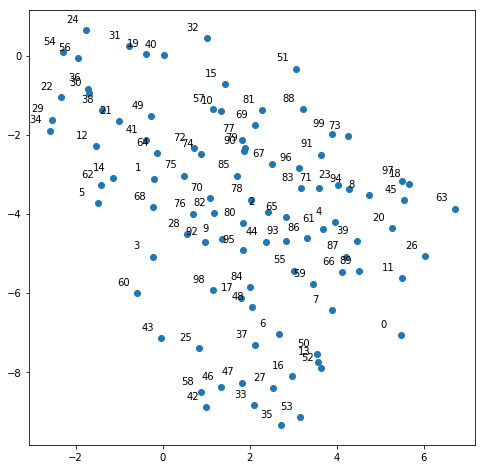

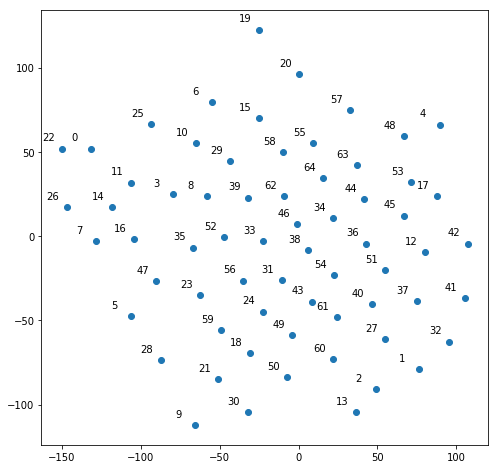

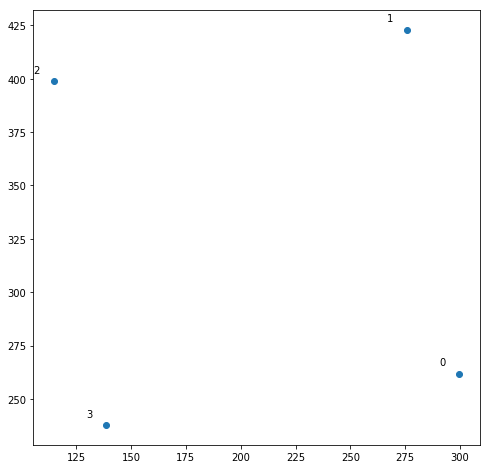

In [73]:
from sklearn.manifold import TSNE
for e in all_em_emb:
    now_em = model.get_layer(name=e).get_weights()
    tsne = TSNE(n_components=2)
    if(not now_em): 
        continue 
    print("type {} len {} shape {} of layer weights".format(type(now_em[0]),len(now_em),now_em[0].shape))
    X_tsne = tsne.fit_transform(now_em[0])
    y_data=whole_data[e[4:]].unique()
    print("len of ydata {}".format(len(y_data)))
    plt.figure(figsize=(8,8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    for i, txt in enumerate(y_data):
        plt.annotate(txt, (X_tsne[i, 0],X_tsne[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
        plt.savefig(str(e[4:])+'.pdf')


#TODO: Analyze any meaningful relations in the above TSNEs.